##### import

In [72]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings(action='ignore')
sns.set_theme(style='whitegrid', font_scale=1.5)  # 테마
sns.set_palette('Set2', n_colors=10)  # 팔레트
plt.rc('font', family='malgun gothic')  # 폰트
plt.rc('axes', unicode_minus=False)  # 마이너스 방지

### 데이터 준비 및 기본 전처리

In [73]:
br = pd.read_csv('data/LPOINT_BIG_COMP_05_BR.csv') # 점포 정보
demo = pd.read_csv('data/LPOINT_BIG_COMP_01_DEMO.csv') # Demo 
Lpay = pd.read_csv('data/LPOINT_BIG_COMP_06_LPAY.csv') # 엘페이 이용
cop = pd.read_csv('data/LPOINT_BIG_COMP_03_COP_U.csv') # 제휴사 이용 정보
buy = pd.read_csv('data/LPOINT_BIG_COMP_02_PDDE.csv') # 상품 구매 정보
pdt = pd.read_csv('data/LPOINT_BIG_COMP_04_PD_CLAC.csv') # 상품 분류 정보

In [74]:
demo ## Demo 
# 고객번호/성별/연령대/거주지대분류코드

,cust,ma_fem_dv,ages,zon_hlv
0,M000034966,여성,40대,Z07
1,M000059535,여성,30대,Z12
2,M000136117,여성,30대,Z11
3,M000201112,여성,50대,Z17
4,M000225114,여성,40대,Z17
...,...,...,...,...
29908,M999708287,여성,40대,Z10
29909,M999770689,여성,30대,Z16
29910,M999849895,여성,20대,Z04
29911,M999926092,남성,30대,Z08


In [75]:
pdt ## 상품 분류 정보
# 상품코드/소분류명/중분류명/대분류명 

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
0,PD0001,소파,가구,거실가구
1,PD0002,스툴/리빙의자,가구,거실가구
2,PD0003,탁자,가구,거실가구
3,PD0004,장식장/진열장,가구,거실가구
4,PD0005,기타가구,가구,기타가구
...,...,...,...,...
1928,PD1929,여성향수,화장품/뷰티케어,향수
1929,PD1930,남성향수,화장품/뷰티케어,향수
1930,PD1931,남녀공용향수,화장품/뷰티케어,향수
1931,PD1932,남성향수세트,화장품/뷰티케어,향수


In [76]:
buy ## 상품 구매 정보
# 고객번호/영수증번호/채널구분/제휴사/상품코드/점포코드/구매일자/구매시간/구매금액/구매수량

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381739,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381740,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1
4381741,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1


#### 사용할 데이터들 merge, 열 전처리 하기

In [77]:
# 상품 분류 정보 + 상품 구매 정보 + Demo(고객 정보)
merged_df = pd.merge(pdt, buy, on='pd_c', how='inner')
merged_df = pd.merge(merged_df, demo, on='cust', how='inner')

##### column name
상품코드/소분류명/중분류명/대분류명/고객번호/영수증번호/채널구분/제휴사/점포코드/구매일자/구매시간/구매금액/구매수량/성별/연령대/거주지대분류코드

In [78]:
merged_df

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm,cust,rct_no,chnl_dv,cop_c,br_c,de_dt,de_hr,buy_am,buy_ct,ma_fem_dv,ages,zon_hlv
0,PD0001,소파,가구,거실가구,M323773246,A01000818330,1,A01,A010017,20210102,14,2960000.0,1,남성,40대,Z17
1,PD0006,책상,가구,사무용/학생용가구,M323773246,A01000941509,1,A01,A010017,20210102,14,3274000.0,1,남성,40대,Z17
2,PD0006,책상,가구,사무용/학생용가구,M323773246,A01000962546,1,A01,A010017,20210102,14,150000.0,1,남성,40대,Z17
3,PD0025,침대,가구,침실가구,M323773246,A01414143163,1,A01,A010017,20211030,15,1020000.0,1,남성,40대,Z17
4,PD0025,침대,가구,침실가구,M323773246,A01414147143,1,A01,A010017,20211030,15,1020000.0,1,남성,40대,Z17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,PD1931,남녀공용향수,화장품/뷰티케어,향수,M432456306,A01142738581,1,A01,A010001,20210420,16,192000.0,1,남성,40대,Z10
4381739,PD1931,남녀공용향수,화장품/뷰티케어,향수,M133831101,A01362046396,1,A01,A010058,20210925,14,220000.0,1,여성,20대,Z10
4381740,PD1931,남녀공용향수,화장품/뷰티케어,향수,M564482610,A01492095718,1,A01,A010041,20211225,10,443000.0,1,남성,20대,Z17
4381741,PD1931,남녀공용향수,화장품/뷰티케어,향수,M673109426,A01500820937,1,A01,A010001,20211230,17,195000.0,1,남성,40대,Z10


In [79]:
merged_df['real_buy_am'] = merged_df['buy_am'] * merged_df['buy_ct'] # 한 상품에 대한 총 구매금액
merged_df['ages'] = merged_df['ages'].apply(lambda x: int(x[:2]))  # ages컬럼 타입 변경 
merged_df['ma_fem_dv'] = merged_df['ma_fem_dv'].replace({'여성': 1, '남성': 0}) # binary encoding 

In [80]:
max_de_dt_by_cust = merged_df.groupby('cust')['de_dt'].max().astype(str).str[4:6].value_counts()
max_de_dt_by_cust # 고객들의 마지막 구매가 대부분 12월, 11월 

12    17828
11     2910
10     1672
09      953
08      706
07      582
05      545
06      454
04      423
03      345
02      252
01      247
Name: de_dt, dtype: int64

=> 데이터가 2021년 한 해밖에 없고, 대부분의 12월, 11월임 고로 RFM 중 R은 제외하고 소비점수 만들 것이다.

#### 군집에 사용할 데이터프레임 cust로 groupby

In [81]:
import pandas as pd

# 예를 들어, 다음과 같이 그룹바이하여 요약 통계를 계산할 수 있습니다.
summary_stats = merged_df.groupby('cust').agg({
    'ma_fem_dv': 'first',  # ma_fem_dv은 그대로 가져옵니다.
    'ages': 'first',  # ages는 그대로 가져옵니다.
    'de_hr': lambda x: x.value_counts().idxmax(),  # de_hr은 가장 많이 나온 값으로 가져옵니다.
    'de_dt': lambda x: x.value_counts().idxmax(),  # de_dt도 가장 많이 나온 값으로 가져옵니다.
    'real_buy_am': ['sum', 'mean'],  # real_buy_am의 합과 평균을 계산합니다.
    'rct_no': 'nunique',  # rct_no 열의 unique값의 개수를 계산합니다.
    'buy_ct': 'sum'  # buy_ct를 모두 더한 값을 계산합니다.
})

# 컬럼 이름을 재설정합니다.
summary_stats.columns = ['성별', '나이', '구매시간', '구매일자', '총구매금액',
                         '평균구매금액', '총구매횟수', '총구매상품개수']

In [82]:
summary_stats

,성별,나이,구매시간,구매일자,총구매금액,평균구매금액,총구매횟수,총구매상품개수
cust,,,,,,,,
M000034966,1,40,16,20210919,783300.0,15358.823529,12,63
M000136117,1,30,15,20210805,27452630.0,251858.990826,70,114
M000201112,1,50,15,20210725,94229.0,4487.095238,5,30
M000225114,1,40,18,20210413,2048440.0,12883.270440,78,182
M000261625,1,40,18,20210713,6496700.0,96965.671642,48,71
...,...,...,...,...,...,...,...,...
M999599111,1,40,19,20210414,1550082.0,45590.647059,8,43
M999673157,0,30,1,20211216,2869290.0,119553.750000,17,28
M999770689,1,30,21,20210213,1535240.0,4873.777778,122,385


### 데이터 탐색

- 각 사용자에 대해 소비를 잘 하는 기준을 선택하고 싶음  => 소비점수를 만들기  
- 그 전에 먼저 boxplot으로 이상치 확인

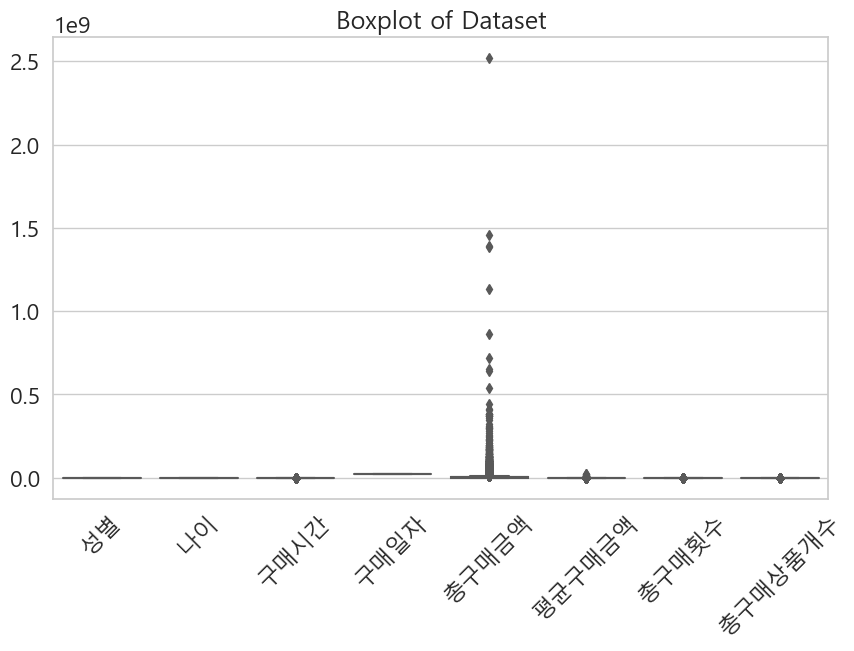

In [83]:
# 주어진 데이터셋의 상자 그림 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary_stats)
plt.title('Boxplot of Dataset')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show();

=> 총구매금액에 따른 이상치가 굉장히 많다.... => 점수를 만들 때 상대적인 값 말고 백분위수를 이용해야겠다.

(이후 군집 분석을 할 때도 이상치로 작용하는 지 안하는 지 모르니까 일단 두고 이상치 제거는 군집 분석할 때 하겠다)

#### 요인 분석을 통한 비슷한 요인 feature 보기 

In [84]:
# pip install factor_analyzer

In [85]:
from factor_analyzer import FactorAnalyzer

In [86]:
# 탐색적요인분석
fa2 = FactorAnalyzer(n_factors=3, rotation='varimax').fit(summary_stats)  # 공통요인이 디폴트는 3임
# 결과 출력
print('요인적재량 :\n',pd.DataFrame(fa2.loadings_, index=summary_stats.columns))

요인적재량 :
                 0         1         2
성별       0.039686 -0.028801  0.072717
나이       0.024550  0.018638  0.282473
구매시간     0.095378 -0.010769 -0.201338
구매일자    -0.034184 -0.001234 -0.135819
총구매금액    0.162036  0.667630 -0.007772
평균구매금액  -0.084389  0.788423 -0.009348
총구매횟수    0.898328  0.070450  0.051107
총구매상품개수  0.866287  0.041453  0.105574


- Factor1
    - 총구매횟수, 총구매상품 개수  
    - 소비 자주하는 Frequency

- Factor2
    - 총구매금액, 평균구매금액  
    - 소비 금액이 큰 Monetary 

=> 크게 둘로 나뉘어서 이 두 요인을 합해 소비점수를 만들기

#### 백분위수로 소비점수 열 만들기

In [87]:
# 총구매금액 열의 백분위수 계산
percentiles = summary_stats['총구매금액'].rank(pct=True)
percentiles_purchase_count = summary_stats['총구매횟수'].rank(pct=True)
percentiles_product_count = summary_stats['총구매상품개수'].rank(pct=True)

# 백분위수를 1에서 10까지의 점수로 변환하여 새로운 열에 저장
summary_stats['총구매금액_점수'] = 1 + (percentiles * 9)
summary_stats['총구매횟수_점수'] = 1 + (percentiles_purchase_count * 9)
summary_stats['총구매상품개수_점수'] = 1 + (percentiles_product_count * 9)

In [88]:
# 소비점수 = 구매금액점수*0.4 + 구매횟수점수*0.3 + 상품개수점수*0.3
summary_stats['소비점수'] = (summary_stats['총구매금액_점수'] * 0.4 +
                            summary_stats['총구매횟수_점수'] * 0.3 +
                            summary_stats['총구매상품개수_점수'] * 0.3)

In [89]:
summary_stats.drop(['총구매금액_점수', '총구매횟수_점수', '총구매상품개수_점수'], axis=1, inplace=True)

In [90]:
summary_stats

,성별,나이,구매시간,구매일자,총구매금액,평균구매금액,총구매횟수,총구매상품개수,소비점수
cust,,,,,,,,,
M000034966,1,40,16,20210919,783300.0,15358.823529,12,63,3.666714
M000136117,1,30,15,20210805,27452630.0,251858.990826,70,114,7.988483
M000201112,1,50,15,20210725,94229.0,4487.095238,5,30,2.280687
M000225114,1,40,18,20210413,2048440.0,12883.270440,78,182,6.853210
M000261625,1,40,18,20210713,6496700.0,96965.671642,48,71,6.853845
...,...,...,...,...,...,...,...,...,...
M999599111,1,40,19,20210414,1550082.0,45590.647059,8,43,3.936945
M999673157,0,30,1,20211216,2869290.0,119553.750000,17,28,4.661121
M999770689,1,30,21,20210213,1535240.0,4873.777778,122,385,7.346961


#### 구매시간을 5개의 시간대로 묶은 구매시간대 열 생성

In [91]:
# 구매시간을 일정 시간대로 묶기 위한 구간 설정
bins = [-1, 5, 11, 16, 20, 23]
labels = ['새벽', '아침', '오후', '저녁', '심야']

# 구간별로 레이블링된 새로운 카테고리 생성
summary_stats['구매시간대'] = pd.cut(summary_stats['구매시간'], bins=bins, labels=labels)

# 각 구매시간대별로 구매시간이 얼마나 많은지 확인
time_slots_count = summary_stats['구매시간대'].value_counts().sort_index()
print(time_slots_count)

새벽      279
아침     2618
오후    11790
저녁    10310
심야     1920
Name: 구매시간대, dtype: int64


In [92]:
df = summary_stats

In [93]:
df = pd.get_dummies(df, columns=['구매시간대'])

In [94]:
df.drop(['구매시간'], axis=1, inplace=True)
df.drop(['소비점수'], axis=1, inplace=True)

In [95]:
df

,성별,나이,구매일자,총구매금액,평균구매금액,총구매횟수,총구매상품개수,구매시간대_새벽,구매시간대_아침,구매시간대_오후,구매시간대_저녁,구매시간대_심야
cust,,,,,,,,,,,,
M000034966,1,40,20210919,783300.0,15358.823529,12,63,0,0,1,0,0
M000136117,1,30,20210805,27452630.0,251858.990826,70,114,0,0,1,0,0
M000201112,1,50,20210725,94229.0,4487.095238,5,30,0,0,1,0,0
M000225114,1,40,20210413,2048440.0,12883.270440,78,182,0,0,0,1,0
M000261625,1,40,20210713,6496700.0,96965.671642,48,71,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
M999599111,1,40,20210414,1550082.0,45590.647059,8,43,0,0,0,1,0
M999673157,0,30,20211216,2869290.0,119553.750000,17,28,1,0,0,0,0
M999770689,1,30,20210213,1535240.0,4873.777778,122,385,0,0,0,0,1


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26917 entries, M000034966 to M999962961
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   성별        26917 non-null  int64  
 1   나이        26917 non-null  int64  
 2   구매일자      26917 non-null  int64  
 3   총구매금액     26917 non-null  float64
 4   평균구매금액    26917 non-null  float64
 5   총구매횟수     26917 non-null  int64  
 6   총구매상품개수   26917 non-null  int64  
 7   구매시간대_새벽  26917 non-null  uint8  
 8   구매시간대_아침  26917 non-null  uint8  
 9   구매시간대_오후  26917 non-null  uint8  
 10  구매시간대_저녁  26917 non-null  uint8  
 11  구매시간대_심야  26917 non-null  uint8  
dtypes: float64(2), int64(5), uint8(5)
memory usage: 1.8+ MB


### 데이터 분석을 통한 문제 해결 (cluster)

- 소비점수 원래 피쳐에서 추가생성한거라 군집분석엔 활용 x
- 구매시간대를 사용하기 위해 원래 구매시간 피쳐 삭제
- 스케일이 다 다르기 때문에 표준화 후 군집 분석 (처음엔 이상치 탐지를 위해, 그래프 시각화를 하기 위해서 pca로 진행)

In [97]:
data = df

In [98]:
# 특징(feature) 선택을 위한 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [99]:
# PCA를 통한 차원 축소
pca = PCA(n_components=2) # 2개의 주성분을 선택
pca_result = pca.fit_transform(scaled_data)

#### 엘보우 방법으로 최적 군집 개수 찾기

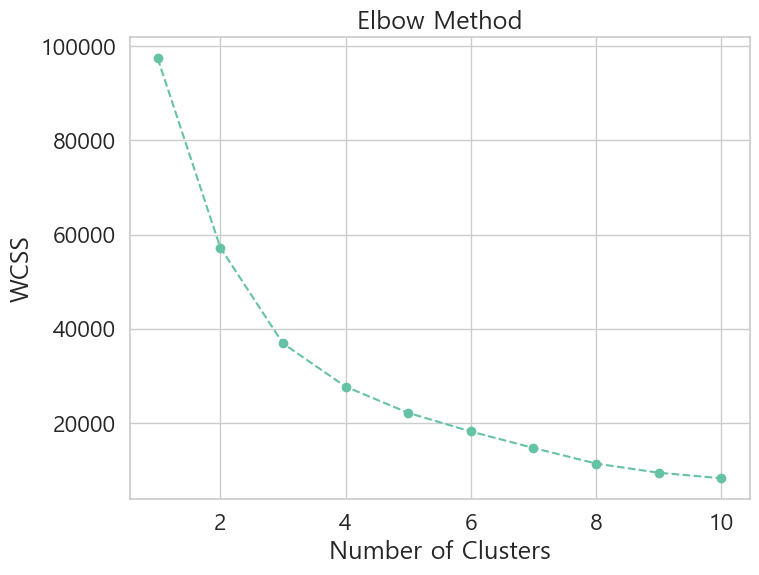

In [100]:
# 엘보우 방법을 사용하여 적절한 군집 개수 결정
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_result)
    wcss.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within Cluster Sum of Squares
plt.show()

=> 4로 결정

#### K-Means 군집화

In [101]:
# K-Means 군집화 수행
kmeans = KMeans(n_clusters=4, random_state=42) # 4개의 군집으로 설정
kmeans.fit(pca_result)
data['Cluster'] = kmeans.labels_

In [102]:
clusters = kmeans.fit_predict(pca_result)

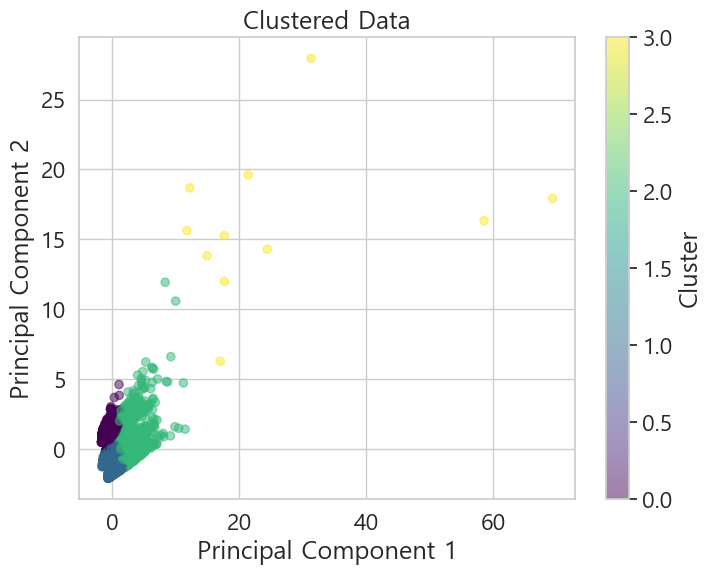

In [103]:
# 클러스터링 결과를 시각화하기 위한 scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.title('Clustered Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

=> 이상치가 너무 크다고 생각됨

##### pca를 통한 그래프 시각화에서 이상치를 제거, 원래 데이터에서도 해당 행 삭제

In [104]:
cluster_centers = kmeans.cluster_centers_
distances = [np.linalg.norm(point - cluster_centers[cluster]) for point, cluster in zip(pca_result, clusters)]

In [105]:
threshold = np.std(distances) * 2  # 표준편차의 두 배

In [106]:
outliers_indices = np.where(distances > threshold)[0]

In [107]:
filtered_data = np.delete(pca_result, outliers_indices, axis=0)
filtered_clusters = np.delete(clusters, outliers_indices)

In [108]:
data1 = data.reset_index()
outliers_indices = np.where(distances > threshold)[0]
data1.drop(data1.index[outliers_indices], inplace=True)

##### 이후 이상치 제거한 데이터를 이용해 원변수로 클러스터링 수행

In [109]:
# 'data' 데이터프레임에서 'Cluster' 열 삭제
data.drop('Cluster', axis=1, inplace=True)

In [110]:
data_without_outliers = data.drop(data.index[outliers_indices])

scaler = StandardScaler()
scaled_data_without_outliers = scaler.fit_transform(data_without_outliers)

##### 실루엣계수를 활용해 최적 군집 개수 (엘보우 방법으로 명확히 안나와서)

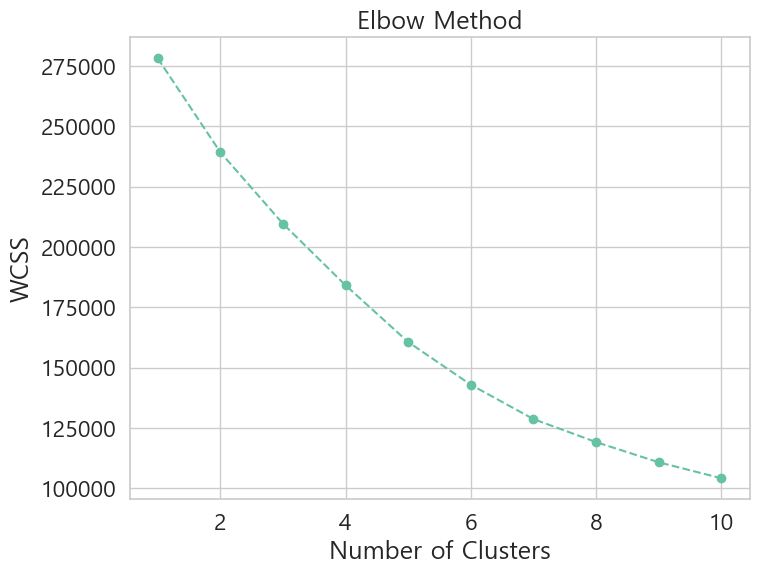

In [111]:
# 엘보우 방법을 사용하여 적절한 군집 개수 결정
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_without_outliers)
    wcss.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')  # Within Cluster Sum of Squares
plt.show()

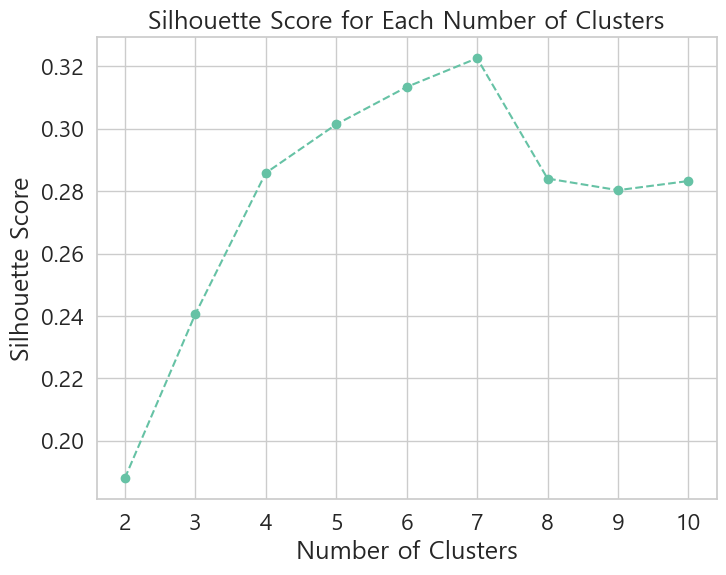

In [112]:
# 최대 군집 개수 설정
max_clusters = 10
silhouette_scores = []

# 실루엣 점수 계산
for num_clusters in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_without_outliers)
    cluster_labels = kmeans.labels_
    
    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(scaled_data_without_outliers, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# 실루엣 점수 시각화
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Each Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

=> 7로 결정

#### K-means 군집화(이상치 제거 후)

In [113]:
# K-Means 군집화 수행 (이상치 제거된 데이터로)
kmeans_filtered = KMeans(n_clusters=7, random_state=42) # 적절한 군집 개수로 설정
kmeans_filtered.fit(scaled_data_without_outliers)
data1['Cluster'] = kmeans_filtered.labels_

clusters_filtered = kmeans_filtered.fit_predict(scaled_data_without_outliers)

### 분석 및 해석

##### 군집 열 추가, 소비점수 열 추가한 최종적인 data1 데이터프레임

In [114]:
data1_cust_values = data1['cust'].tolist()
summary_stats_filtered = summary_stats[summary_stats.index.isin(data1_cust_values)]
data1['소비점수'] = summary_stats.loc[data1['cust'], '소비점수'].values
data1

,cust,성별,나이,구매일자,총구매금액,평균구매금액,총구매횟수,총구매상품개수,구매시간대_새벽,구매시간대_아침,구매시간대_오후,구매시간대_저녁,구매시간대_심야,Cluster,소비점수
0,M000034966,1,40,20210919,783300.0,15358.823529,12,63,0,0,1,0,0,3,3.666714
1,M000136117,1,30,20210805,27452630.0,251858.990826,70,114,0,0,1,0,0,3,7.988483
2,M000201112,1,50,20210725,94229.0,4487.095238,5,30,0,0,1,0,0,3,2.280687
3,M000225114,1,40,20210413,2048440.0,12883.270440,78,182,0,0,0,1,0,0,6.853210
4,M000261625,1,40,20210713,6496700.0,96965.671642,48,71,0,0,0,1,0,0,6.853845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26910,M999492154,1,20,20210922,74800.0,18700.000000,1,4,0,0,1,0,0,3,1.522122
26911,M999515910,0,40,20211021,8802255.0,15946.114130,33,770,0,0,1,0,0,3,8.186208
26912,M999599111,1,40,20210414,1550082.0,45590.647059,8,43,0,0,0,1,0,0,3.936945
26914,M999770689,1,30,20210213,1535240.0,4873.777778,122,385,0,0,0,0,1,2,7.346961


##### 군집별 구매시간대가 확연히 나누어지는지 확인

In [115]:
cluster_features = data1.groupby('Cluster')['구매시간대_새벽','구매시간대_아침','구매시간대_오후','구매시간대_저녁','구매시간대_심야'].mean()

In [116]:
cluster_features

,구매시간대_새벽,구매시간대_아침,구매시간대_오후,구매시간대_저녁,구매시간대_심야
Cluster,,,,,
0,0.0,0.000000,0.000000,1.000000,0.000000
1,0.0,0.284834,0.000000,0.506782,0.208385
2,0.0,0.000000,0.000000,0.000000,1.000000
3,0.0,0.000000,1.000000,0.000000,0.000000
4,1.0,0.000000,0.000000,0.000000,0.000000
5,0.0,1.000000,0.000000,0.000000,0.000000
6,0.0,0.088068,0.420455,0.454545,0.036932


> 군집 0 저녁  
군집 1 아침, 저녁, 심야  
군집 2 심야  
군집 3 오후  
군집 4 새벽  
군집 5 아침  
군집 6 오후, 저녁

=> 한 시간대만 있는 군집도 있고 몇개의 시간대 합쳐진 군집도 있음

##### 군집별 원소 개수 확인 (군집이 7개로 꽤 많아 확인필수)

In [117]:
data1['Cluster'].value_counts() 

3    9984
0    8233
5    2087
2    1570
1     811
6     352
4     148
Name: Cluster, dtype: int64

In [118]:
data1 = data1[~data1['Cluster'].isin([1, 6, 4])] #1000개 이하 군집 삭제

##### 군집별 구매시간대가 확연히 나누어지는지 확인

In [121]:
cluster_features = data1.groupby('Cluster')['구매시간대_새벽','구매시간대_아침','구매시간대_오후','구매시간대_저녁','구매시간대_심야'].mean()
cluster_features

,구매시간대_새벽,구매시간대_아침,구매시간대_오후,구매시간대_저녁,구매시간대_심야
Cluster,,,,,
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0


In [120]:
data1['Cluster'].replace({5: 0, 3: 1, 0: 2, 2: 3}, inplace=True)

> 군집 0: 아침  
군집 1: 오후  
군집 2: 저녁  
군집 3: 심야  

##### 군집별 나이 특징

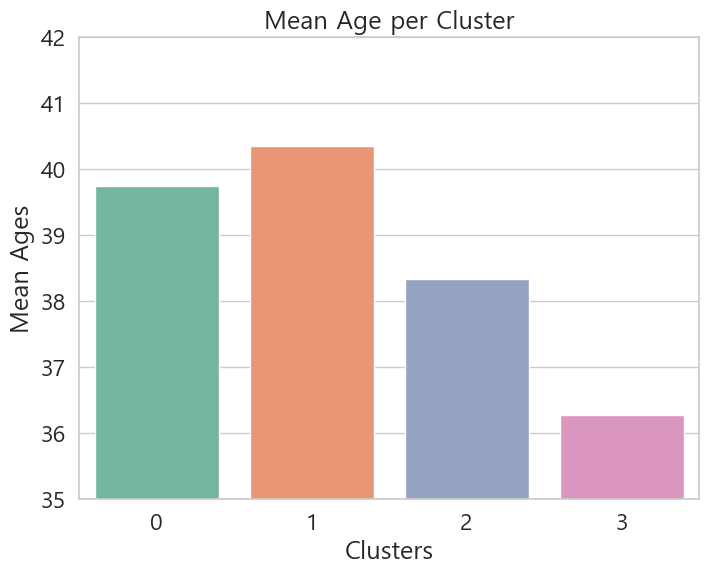

In [59]:
mean_age_per_cluster = data1.groupby('Cluster')['나이'].mean()

# 막대 그래프로 평균값 비교
plt.figure(figsize=(8, 6))
sns.barplot(x=mean_age_per_cluster.index, y=mean_age_per_cluster.values)
plt.ylim(35, 42)
plt.xlabel('Clusters')
plt.ylabel('Mean Ages')
plt.title('Mean Age per Cluster')
plt.show()

=> 오후 시간대에 평균연령이 가장 높고 심야 시간대에 평균연령이 가장 낮다

##### 군집별 나이 특징

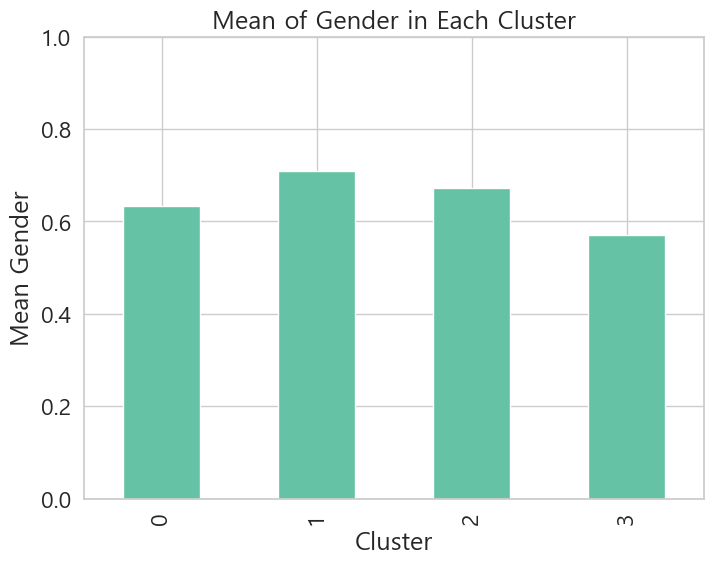

In [71]:
# 각 클러스터 그룹에서 성별에 대한 평균 찾기
mean_sex_per_cluster = data1.groupby('Cluster')['성별'].mean()

# 막대 그래프로 평균값 비교
plt.figure(figsize=(8, 6))
mean_sex_per_cluster.plot(kind='bar')
plt.title('Mean of Gender in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Gender')

# y축 범위 설정
plt.ylim(0, 1)

plt.show()

=> 군집1 오후에 여성이 비교적 많고, 군집3 심야에 남성이 비교적 구매를 많이함

##### 가장 차이가 큰 군집1(오후), 군집3(심야) 연령별로 차이 보기

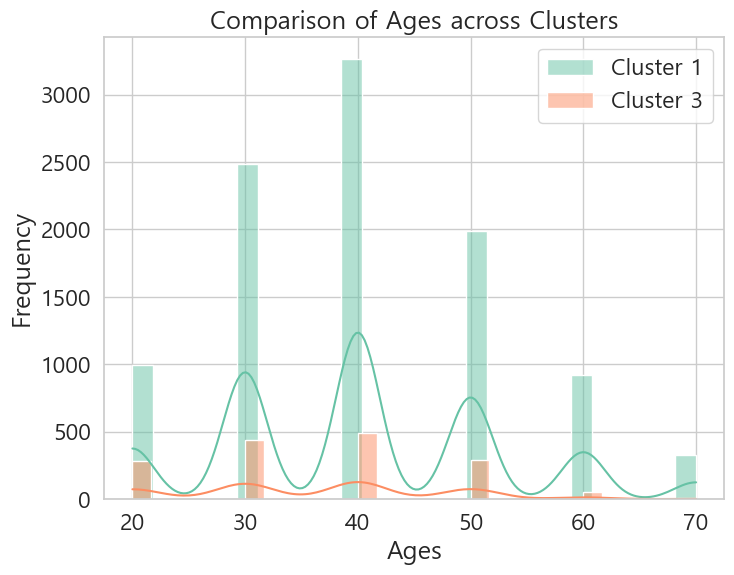

In [50]:
plt.figure(figsize=(8, 6))

# 군집별 히스토그램 그리기
for cluster_value in [1, 3]:
    cluster_data = data1[data1['Cluster'] == cluster_value]['나이']
    sns.histplot(cluster_data, label=f'Cluster {cluster_value}', kde=True)

plt.title('Comparison of Ages across Clusters')
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.legend()
plt.show()

=> 오후의 데이터 개수가 훨씬 많아서 보정 진행

##### 각 군집 데이터 개수가 동일한 경우 연령별 차이 보기

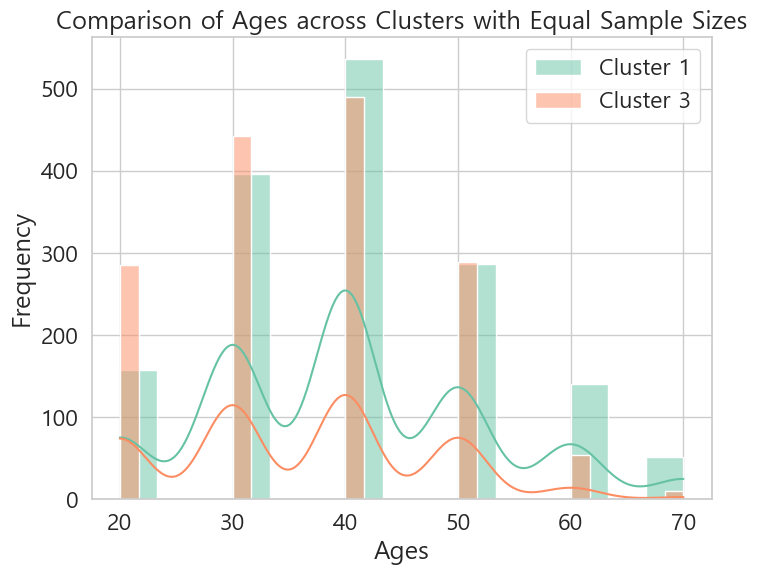

In [51]:
plt.figure(figsize=(8, 6))

# 각 군집 데이터 개수가 동일한 경우
num_samples = data1['Cluster'].value_counts().min()

for cluster_value in [1,3]:
    cluster_data = data1[data1['Cluster'] == cluster_value].sample(num_samples)['나이']
    sns.histplot(cluster_data, label=f'Cluster {cluster_value}', kde=True)

plt.title('Comparison of Ages across Clusters with Equal Sample Sizes')
plt.xlabel('Ages')
plt.ylabel('Frequency')
plt.legend()
plt.show()

=> 20,30 대는 확연하게 군집3(심야)에 사람이 많고, 60,70대는 군집1(오후)에 사람이 많다

> **노년층을 위한 물품 행사는 오후 쯤에 실시하고, 청년층을 위한 이벤트는 심야 쯤에 실시하면 더 효율적인 마케팅 가능**

##### 군집별 소비점수 차이

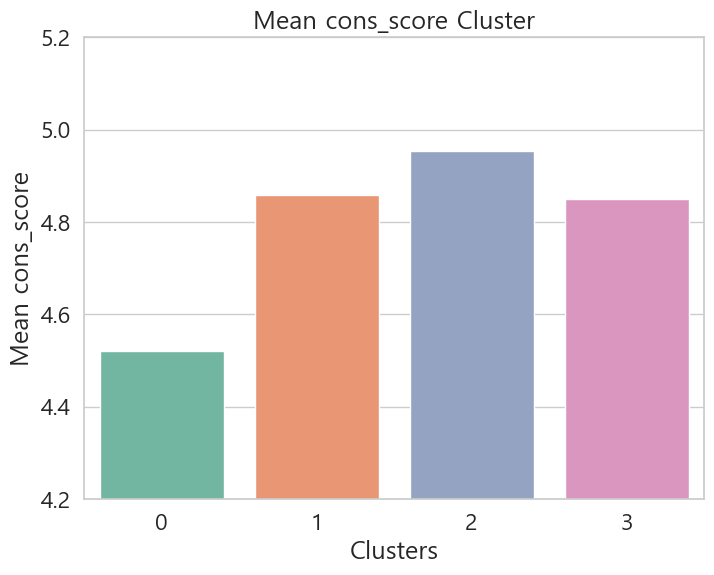

In [52]:
cons_score_cluster = data1.groupby('Cluster')['소비점수'].mean()

# 막대 그래프로 평균값 비교
plt.figure(figsize=(8, 6))
sns.barplot(x=cons_score_cluster.index, y=cons_score_cluster.values)
plt.xlabel('Clusters')
plt.ylim(4.2,5.2)
plt.ylabel('Mean cons_score')
plt.title('Mean cons_score Cluster')
plt.show()

=> 소비점수의 평균이 군집0(아침)에 가장 낮게 나옴

=> 가장 차이가 큰 군집0(아침)과 군집2(저녁)은 약 0.4~5점 차이남

이후 할 일
군집별로 data custid 확인해서 원본 데이터에서 어떤 상품군(상품대분류)을 많이 샀는 지 확인

등등